# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
import json
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3


In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"

eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"



In [5]:
# Fetch current BTC price by executing GET request and formatting as json
btc_response = requests.get(btc_url).json()

# Select the BTC price from the data above
btc_price = btc_response["data"]["1"]["quotes"]["USD"]["price"]

# Fetch current ETH price
eth_response = requests.get(eth_url).json()

# Select the ETH price from the data above
eth_price = eth_response["data"]["1027"]["quotes"]["USD"]["price"]

# Compute current value of my crpto
my_btc_value = my_btc * btc_price 
my_eth_value = my_eth * eth_price 

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $64740.00
The current value of your 5.3 ETH is $18964.94


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
# Format current date as ISO format
start = pd.Timestamp("2021-10-07", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-10-07", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_barset(
    tickers,
    timeframe,
    start = start,
    end = end,
    limit = 1000
).df

# Preview DataFrame
df_portfolio.head()


AGG                                     SPY  \
                             open   high     low   close   volume    open   
time                                                                        
2021-10-07 00:00:00-04:00  114.46  114.5  114.34  114.36  3586652  438.39   

                                                            
                             high    low   close    volume  
time                                                        
2021-10-07 00:00:00-04:00  441.68  438.2  438.64  64139858

In [9]:
# Fetch AGG and SPY close prices
## Create an empty DataFrame for closing prices
closing_prices = pd.DataFrame()

closing_prices ["AGG"] = df_portfolio["AGG"]["close"]
closing_prices["SPY"] = df_portfolio["SPY"]["close"]

## Drop the time component of the date and convert "close" prices from string to an integer
closing_prices.index = closing_prices.index.date

agg_close_price = float(df_portfolio["AGG"]["close"])
spy_close_price = float(df_portfolio["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $114.36
Current SPY closing price: $438.64


In [10]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of shares
print(f"The current value of the {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of the {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of the 50 SPY shares is $21932.00
The current value of the 200 AGG shares is $22872.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = my_btc_value + my_eth_value
shares = my_spy_value + my_agg_value


# Create savings DataFrame
data = {" ": ["crypto", "shares"],
    "amount": [crypto, shares]
    }
df_savings = pd.DataFrame(data).set_index(" ")

# Display savings DataFrame
df_savings

,amount
,
crypto,83704.937
shares,44804.000


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

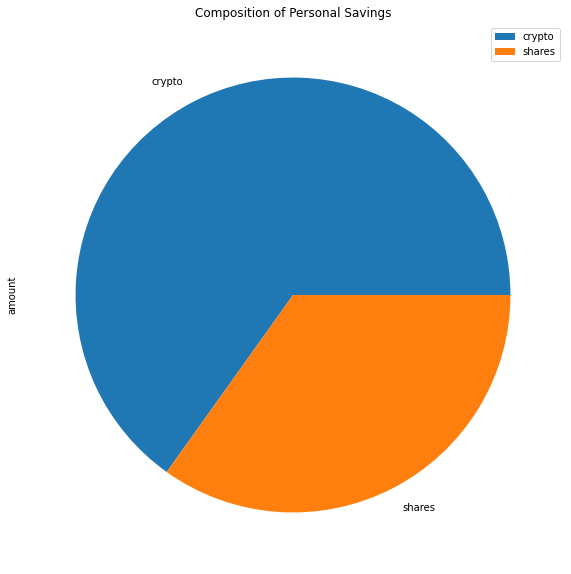

In [12]:
# Plot savings pie chart
df_savings.plot(kind='pie', x = " ", y= "amount", title = "Composition of Personal Savings", figsize = (10,10))

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings and difference to determine if additional savings are required to reach financial goal
total_savings = crypto + shares
diff_amount = total_savings - emergency_fund

# Validate saving health 
if total_savings > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund and more.")
elif total_savings == emergency_fund:
    print("Congradulations! You have reached your financial goal")
else: 
    print(f"Sorry, you need ${diff_amount:0.2f} to achieve you financial goal")

Congratulations! You have enough money in your emergency fund and more.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-10-07', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-10-07', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = 1000
).df

# Display sample data
df_stock_data.tail()

AGG                                        SPY  \
                             open     high      low   close   volume    open   
time                                                                           
2021-10-01 00:00:00-04:00  114.82  115.060  114.790  115.02  6840179  430.98   
2021-10-04 00:00:00-04:00  114.92  115.030  114.795  114.94  3969883  433.00   
2021-10-05 00:00:00-04:00  114.82  114.867  114.610  114.65  6211634  430.24   
2021-10-06 00:00:00-04:00  114.68  114.730  114.590  114.70  4748378  429.27   
2021-10-07 00:00:00-04:00  114.46  114.500  114.340  114.36  3586652  438.39   

                                                                
                               high     low   close     volume  
time                                                            
2021-10-01 00:00:00-04:00  436.0329  427.24  434.19  110774792  
2021-10-04 00:00:00-04:00  433.9600  426.36  428.69  112134374  
2021-10-05 00:00:00-04:00  435.4900  429.39  433.05   82381830  
2021-10-06 00:00:00-04:00  435.1199  427.54  434.92   99477866  
2021-10-07 00:00:00-04:00  441.6800  438.20  438.64   64139858

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
MC_30year.portfolio_data.head()

AGG                                     \
                             open     high     low    close   volume   
time                                                                   
2017-10-18 00:00:00-04:00  109.51  109.560  109.46  109.530  1511319   
2017-10-19 00:00:00-04:00  109.71  109.750  109.54  109.610  1747693   
2017-10-20 00:00:00-04:00  109.32  109.405  109.26  109.305  1768427   
2017-10-23 00:00:00-04:00  109.40  109.470  109.36  109.410  1571621   
2017-10-24 00:00:00-04:00  109.23  109.290  109.17  109.200  1492997   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2017-10-18 00:00:00-04:00          NaN  255.90  255.95  255.50  255.69   
2017-10-19 00:00:00-04:00     0.000730  254.82  255.82  254.35  255.82   
2017-10-20 00:00:00-04:00    -0.002783  256.70  257.14  256.42  257.08   
2017-10-23 00:00:00-04:00     0.000961  257.48  257.51  256.02  256.15   
2017-10-24 00:00:00-04:00    -0.001919  256.59  256.83  256.15  256.55   

                                                  
                             volume daily_return  
time                                              
2017-10-18 00:00:00-04:00  25173613          NaN  
2017-10-19 00:00:00-04:00  41439302     0.000508  
2017-10-20 00:00:00-04:00  41153383     0.004925  
2017-10-23 00:00:00-04:00  36345830    -0.003618  
2017-10-24 00:00:00-04:00  51308377     0.001562

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\Krishan Kandial\Desktop\Miami\FinTech\MiamiHW\Homework5\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996553,1.017065,0.994712,1.002772,1.010124,1.010001,0.999035,0.991688,0.996728,0.997134,...,1.002499,0.993150,1.004661,0.987828,0.995121,1.006656,0.985528,0.989030,1.006638,0.990517
2,1.001357,1.016123,0.992993,0.999010,1.010411,0.998317,0.996034,0.989994,0.993009,1.014793,...,1.012649,0.984330,0.999987,0.990880,1.000215,1.002583,0.983910,1.001967,1.010403,0.990942
3,0.996694,1.009692,0.993718,1.011577,1.007116,1.003331,0.999457,0.992581,0.992921,1.016760,...,1.021260,0.978311,1.004019,0.995702,1.007648,1.003076,0.993150,1.000866,1.010367,0.993966
4,0.999010,0.993151,0.999638,1.005042,0.993898,1.020118,1.009646,1.008229,0.991200,1.020900,...,1.025439,0.981931,1.001900,1.002100,1.016104,1.002601,1.004710,1.001667,1.024815,1.003595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,48.368437,10.480119,56.571434,12.582571,24.095626,12.423860,52.555112,11.402257,9.024840,10.740695,...,23.081112,11.838464,18.990482,7.119037,15.586173,6.430403,24.977436,14.468899,32.052499,4.241719
7557,48.846553,10.548937,56.186320,12.659876,23.966434,12.284560,52.035205,11.402945,9.085562,10.729295,...,23.192700,11.883135,19.002448,7.164685,15.485630,6.471274,24.938014,14.291488,32.032690,4.214009
7558,48.661438,10.592332,56.253837,12.511972,24.041671,12.271400,52.388545,11.222294,9.141887,10.767077,...,23.231592,11.745955,19.242030,7.158008,15.554967,6.525827,25.263335,14.511380,31.942624,4.154703
7559,48.869279,10.511013,56.593592,12.659486,24.111493,12.265774,52.041150,11.257593,9.161960,10.887992,...,23.213522,11.835219,19.383712,7.274364,15.520983,6.526662,24.697272,14.440377,31.933061,4.195894


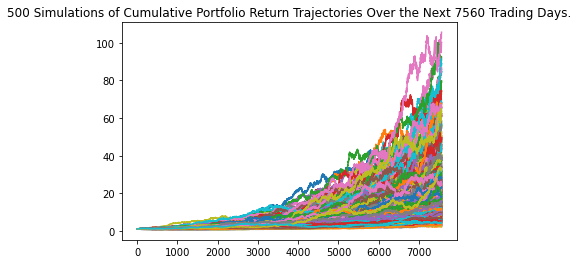

In [31]:
# Plot simulation outcomes
line_plot = MC_30year.plot_simulation()


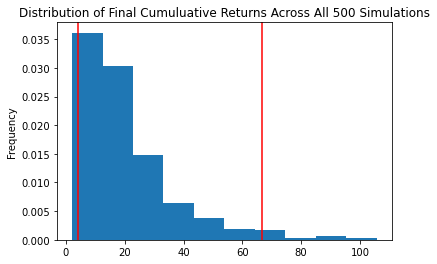

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30year.plot_distribution()


### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_30year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean             20.681918
std              16.224633
min               2.140377
25%               9.513154
50%              15.635483
75%              25.359132
max             105.631212
95% CI Lower      4.282424
95% CI Upper     66.785902
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment_1 = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment_1,2)
ci_upper = round(tbl[9]*initial_investment_1,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_1} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $85648.48 and $1335718.04


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment_2 = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment_2,2)
ci_upper = round(tbl[9]*initial_investment_2,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_2} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $128472.72 and $2003577.07


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [29]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

NameError: name 'initial_investment' is not defined

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004461,1.003269,0.998934,0.996767,1.000906,0.999279,0.995262,1.005752,0.993466,0.993655,...,1.001427,1.004350,0.996932,0.996844,0.997507,1.003457,0.998736,1.001195,0.999904,1.010218
2,1.007901,1.003304,0.993812,0.999973,1.000910,1.002347,0.996311,1.007234,0.993550,0.991021,...,0.997379,1.001952,0.998124,0.998063,1.001733,1.000273,0.994865,1.000109,0.994648,1.007838
3,1.007532,1.001077,0.990963,0.998339,1.001779,1.003653,0.994439,1.012230,0.999170,0.996484,...,0.995265,1.001745,0.995332,1.003023,1.003800,0.999755,0.997616,1.004730,0.993391,1.010444
4,1.020339,1.005743,0.991869,0.998218,1.005630,1.008717,0.987764,1.012750,0.999227,0.996474,...,0.999028,1.004730,0.995357,1.000204,1.008738,0.999273,0.999426,1.003776,0.991478,1.013379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.616922,1.761703,1.143430,1.687801,1.743826,1.174891,1.514199,2.447129,1.589765,1.570578,...,1.316494,1.863650,1.727959,1.411033,1.804671,1.500605,1.413278,1.552375,1.318340,1.960015
2517,1.620285,1.769184,1.145132,1.695693,1.742878,1.175745,1.517697,2.441471,1.586174,1.560826,...,1.318463,1.857860,1.724003,1.409092,1.810136,1.499466,1.413210,1.552539,1.316872,1.956776
2518,1.622141,1.771927,1.149019,1.691589,1.739420,1.178965,1.522624,2.444413,1.580680,1.566154,...,1.317147,1.864694,1.727503,1.419561,1.821212,1.492831,1.412283,1.556659,1.318842,1.961271
2519,1.628885,1.770207,1.149670,1.703935,1.738053,1.182429,1.519485,2.441360,1.565663,1.576607,...,1.307985,1.858986,1.728039,1.430017,1.814690,1.496851,1.409284,1.562660,1.324798,1.964190


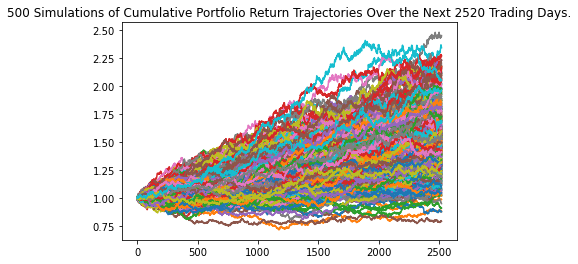

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

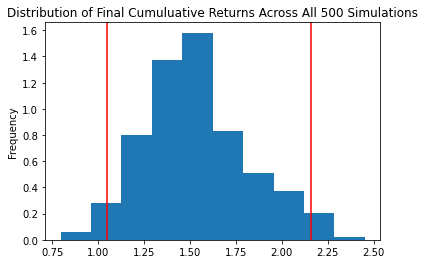

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.537014
std               0.282192
min               0.795263
25%               1.339641
50%               1.523799
75%               1.693927
max               2.451787
95% CI Lower      1.049781
95% CI Upper      2.159935
Name: 2520, dtype: float64


In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $62986.85 and $129596.12
